# Challenge  : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [39]:
!pip install plotly -q
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error,classification_report
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display
warnings.filterwarnings("ignore")
sns.set()

# Read file with labels

In [40]:
data = pd.read_csv('/content/conversion_data_train (1).csv')
print('Number of rows and columns:', data.shape)

Number of rows and columns: (284580, 6)


In [41]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


- Pas de valeurs manquantes 

In [43]:
sorted(data['age'],reverse=True)[:10]

[123, 111, 79, 77, 73, 72, 70, 70, 69, 68]

- Il y a deux âges irréalistes (123 et  111) donc je vais les supprimer.

In [44]:
print(data.loc[data['age']==123])
print(data.loc[data['age']==111])

        country  age  new_user source  total_pages_visited  converted
233196  Germany  123         0    Seo                   15          1
      country  age  new_user source  total_pages_visited  converted
11331      UK  111         0    Ads                   10          1


In [45]:
data.drop([233196,11331],inplace=True)

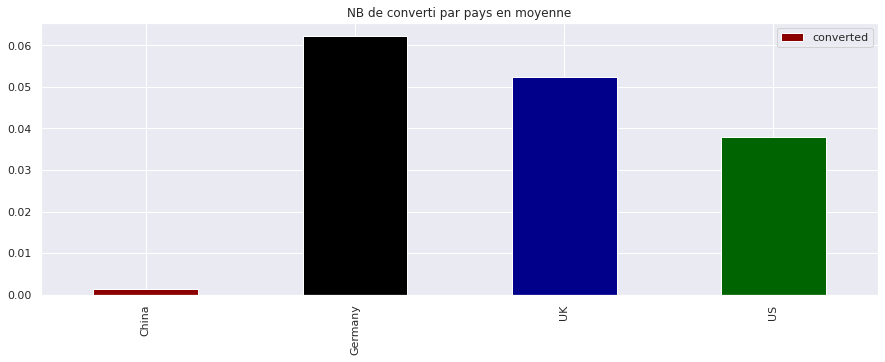

In [46]:
data_country = data.groupby(['country']).mean()
data_country['converted'].plot(kind='bar',
                    title='NB de converti par pays en moyenne',
                    ylabel='',
                    xlabel='',
                    color=['darkred','black','darkblue','darkgreen'],
                    figsize=(15, 5),
                    legend = True)

- les gens se convertissent plus en Germany, Royaume-Uni suivi des États-Unis

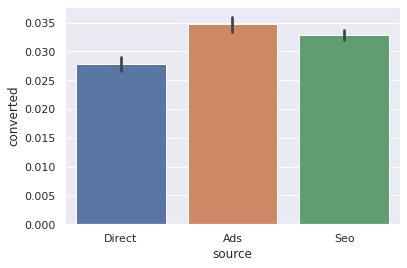

In [47]:
sns.barplot(x='source',y='converted',data=data)

- La plupart des gens viennent des ADS, suivis du Seo, puis Direct Sorce.

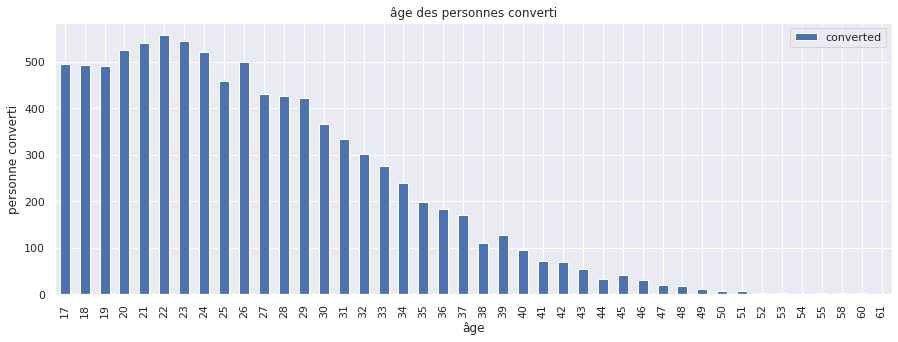

In [48]:
age_converted = (data['converted'] == 1)
age_converted = data.loc[age_converted,:]
age_converted

data_age_converted = age_converted.groupby(['age']).count()
data_age_converted['converted'].plot(kind='bar',
                    title='âge des personnes converti',
                    ylabel='personne converti',
                    xlabel='âge',
                    figsize=(15, 5),
                    legend = True)
plt.show()

- l'age des utilisateurs converti varie principalement entre 17 et 37 ans on remarque egalement que nous avons des données aberrante avec des âge allant jusqu'a 123 ans

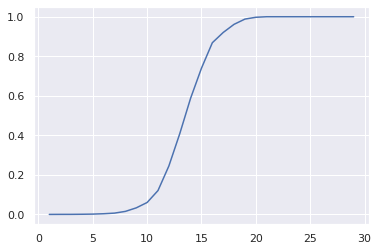

In [49]:
data_pages = data.groupby('total_pages_visited')[['converted']].mean()
data_ages = data.groupby('age')[['converted']].mean()
plt.plot(data_pages.index,data_pages['converted'])

- Ce graphique montre que lorsque les utilisateurs visitent plus de pages, la probabilité de conversion augmente

total_pages_visited    0.529171
new_user               0.152075
age                    0.088711
Name: converted, dtype: float64

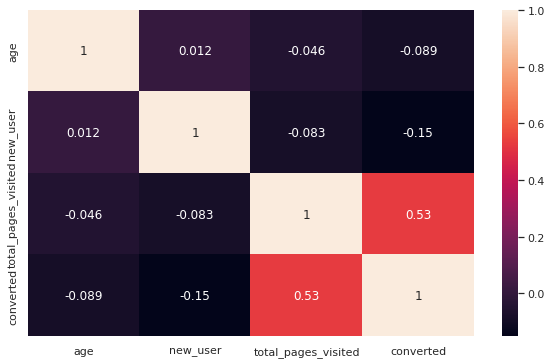

In [50]:
fig = plt.figure(1, figsize=(10, 6))
sns.heatmap(data.corr(), annot=True)
data.corr()["converted"].abs().sort_values(ascending=False).iloc[1:4]

# Prediction model

**Baseline model (logistic regression)**

In [51]:
target_variable = 'converted'
Y = data.loc[:, target_variable]
X = data.loc[:, [c for c in data.columns if c != target_variable]]

print('Explanatory variables : ', X.columns)
print()
# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)


Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [52]:
#Convert pandas DataFrames to numpy arrays...
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

In [53]:
# Create pipeline for numeric features
numeric_features = [1, 4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # if still missing values we will replace by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = [0, 2, 3] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if still missing values we will replace by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

#OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train and test set
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) # Don't fit again on test!!

In [54]:
# Train model
classifierR = LogisticRegression()
classifierR.fit(X_train, Y_train) # Training is always done on train set !!


# Predictions on training set
y_train_pred = classifierR.predict(X_train)
# Predictions on test set
y_test_pred = classifierR.predict(X_test)

print("f1-score on train set : %.3f" % f1_score(Y_train, y_train_pred))
print("f1-score on test set : %.3f" % f1_score(Y_test, y_test_pred))


f1-score on train set : 0.765
f1-score on test set : 0.748


In [55]:
# Computing other performance metrics to better understand what the model is doing : Classifier
print(classification_report(Y_test, classifierR.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27500
           1       0.85      0.67      0.75       958

    accuracy                           0.98     28458
   macro avg       0.92      0.83      0.87     28458
weighted avg       0.98      0.98      0.98     28458



Nous avons 99% de chance pour la classe 0 et 85% de chance pour la classe 1 qu'elle soit bien 0 et 1. De plus nous avons 100% de tout les non convertis que nous arrivons à bien prédire comme non converti, et 67% pour prédit comme bien converti.

Le F1-score prend en compte la moyenne du déséquilibre entre le recall et la précision avec un F1-score à 99% et 75% montre l'exactitude de nos 2 metriques précédentes.

Dans le support on remarque un désequilibre entre les 2 classes nous avons beaucoup plus de 0 que de 1

**Decision Tree**
- Modèle qui divise l'ensemble de données successivement pour produire la prédiction
- A chaque étape de division, le modèle sélectionne la variable et la valeur seuil qui permettent d'obtenir les deux sous-ensembles de données dans lesquels la variable cible sera la plus homogène possible
- Le modèle arrête de diviser l'ensemble de données lorsque toutes les branches contiennent des sous-ensembles de données dans lesquels la variable cible est homogène (la même valeur pour toutes les observations)
- L'objectif est de minimiser la somme de l'hétérogénéité des branches et de jouer sur les critères d'arrêt pour obtenir un compromis biais/variance optimal

In [56]:
# Create a random tree
classifier = DecisionTreeClassifier()
classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [57]:
# Determining best hyperparameters
max_depth = [5,6,7,8, 9,10]
min_samples_split = [7,8,9,10,11,12,13]

gread_select = GridSearchCV(estimator=DecisionTreeClassifier(), cv=3,
                       param_grid={"max_depth":max_depth, "min_samples_split":min_samples_split})

gread_select.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'min_samples_split': [7, 8, 9, 10, 11, 12, 13]})

In [58]:
print("Hyperparameters that give the best score : ", gread_select.best_params_)
print("Best score : %.3f" % gread_select.best_score_)

Hyperparameters that give the best score :  {'max_depth': 8, 'min_samples_split': 9}
Best score : 0.986


In [59]:
# Apply the grid search outputs into the Decision Tree Classifier
Decision_tree = DecisionTreeClassifier(max_depth=gread_select.best_params_['max_depth'],
                           min_samples_split=gread_select.best_params_['min_samples_split'])
Decision_tree.fit(X_train, Y_train)

# Predictions on training set
y_train_pred = Decision_tree.predict(X_train)

# Predictions on test set
y_test_pred = Decision_tree.predict(X_test)

In [60]:
# The f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : %.3f" % f1_score(Y_train, Decision_tree.predict(X_train)))
print("f1-score on test set : %.3f" % f1_score(Y_test, Decision_tree.predict(X_test)))

f1-score on train set : 0.765
f1-score on test set : 0.745


The confusion matrix  on test set


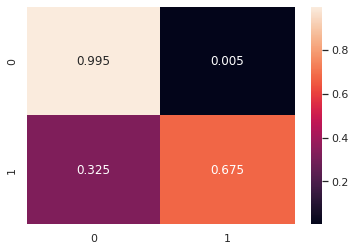

In [61]:
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");
print('The confusion matrix  on test set')

Dans les données de test, le nombre de non convertie classé comme non convertie corespond à 99,5 %. Dans les données de test, le nombre de converti classé comme converti est correct à 67 %.

on constate également que nous avons un biais de 32% ou les converties sont classé comme non converti

In [62]:
# Computing other performance metrics to better understand what the model is doing : random tree
print(classification_report(Y_test, Decision_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27500
           1       0.83      0.68      0.74       958

    accuracy                           0.98     28458
   macro avg       0.91      0.84      0.87     28458
weighted avg       0.98      0.98      0.98     28458



- On remarque un désequilibre entre les 2 classes nous avons beaucoup plus de 0 que de 1

**Random Forest**
- Un ensemble d'arbres aléatoires rassemblés par le Bagging
-  Bagging: Bootstrap + Aggregating, consiste à former plusieurs modèles pour résoudre le même problème de prédiction et à combiner leurs forces pour améliorer les résultats
- Bootstrap: Générer aléatoirement divers jeux de données, qui ressemblent aux données d'origine, sans leur être identiques (apprentissage de modèles sur des données variées)
-  Parameter: n_estimators is the number of trees in the forest



In [63]:
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)

RandomForestClassifier()

In [64]:
# Determining best hyperparameters
max_depth = [7,12,15,20, 25]
min_samples_split = [20,30,40,50,60,70]
n_estimators = (25,45,50,60,70,80)

gread_select = GridSearchCV(estimator=RandomForestClassifier(), cv=3,
                       param_grid={"max_depth":max_depth,
                                   "min_samples_split":min_samples_split,
                                   "n_estimators":n_estimators})

gread_select.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 12, 15, 20, 25],
                         'min_samples_split': [20, 30, 40, 50, 60, 70],
                         'n_estimators': (25, 45, 50, 60, 70, 80)})

In [65]:
print("Hyperparameters that give the best score : ", gread_select.best_params_)
print("Best score : %.3f" % gread_select.best_score_)


Hyperparameters that give the best score :  {'max_depth': 15, 'min_samples_split': 70, 'n_estimators': 60}
Best score : 0.986


In [66]:
random_forest = RandomForestClassifier(n_estimators = gread_select.best_params_['n_estimators'], max_depth=gread_select.best_params_['max_depth'],
                           min_samples_split=gread_select.best_params_['min_samples_split'])
random_forest.fit(X_train, Y_train)

print('Best param :',gread_select.best_params_)

Best param : {'max_depth': 15, 'min_samples_split': 70, 'n_estimators': 60}


In [67]:
# Predictions on training set
y_train_pred = random_forest.predict(X_train)

# Predictions on test set
y_test_pred = random_forest.predict(X_test)

print("f1-score on train set : %.3f" % f1_score(Y_train, random_forest.predict(X_train)))
print("f1-score on test set : %.3f" % f1_score(Y_test, random_forest.predict(X_test)))

f1-score on train set : 0.772
f1-score on test set : 0.749


TEST SET : RANDOM FOREST
---


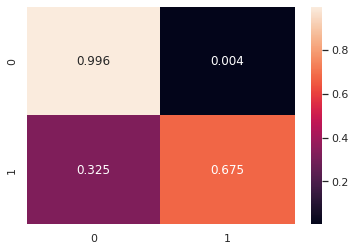

In [68]:
print('TEST SET : RANDOM FOREST')
print('---')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");


In [69]:
# Computing other performance metrics to better understand what the model is doing : random forest
print(classification_report(Y_test, random_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     27500
           1       0.84      0.68      0.75       958

    accuracy                           0.98     28458
   macro avg       0.91      0.84      0.87     28458
weighted avg       0.98      0.98      0.98     28458



- Nous avons 99% de chance pour la classe 0 et 84% de chance pour la classe 1 qu'elle soit bien 0 et 1. De plus nous avons 100% de tout les non convertis que nous arrivons à bien prédire comme non converti, et 68% pour prédit comme bien converti.


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [70]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

RandomForestClassifier()

In [73]:
# Read data without labels
data_without_labels = pd.read_csv('/content/conversion_data_train (1).csv')
print('Prediction set (without labels) :', data_without_labels.shape)

#features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, data_without_labels.columns]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (284580, 6)
Convert pandas DataFrames to numpy arrays...
...Done
[['China' 22 1 'Direct' 2 0]
 ['UK' 21 1 'Ads' 3 0]
 ['Germany' 20 0 'Seo' 14 1]
 ['US' 23 1 'Seo' 3 0]
 ['US' 28 1 'Direct' 3 0]]


In [74]:
# Create pipeline for categorical features
categorical_features = [0, 2, 3]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if still missing values we will replace by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Create pipeline for numeric features
numeric_features = [1, 4] 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # if still missing values we will replace by columns' mean
    ('scaler', StandardScaler())
])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_without_labels = preprocessor.fit_transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])


...Done
[[-1.03597878 -0.85974314  0.          0.          0.          1.
   1.          0.        ]
 [-1.15694494 -0.5605201   0.          1.          0.          1.
   0.          0.        ]
 [-1.2779111   2.73093333  1.          0.          0.          0.
   0.          1.        ]
 [-0.91501263 -0.5605201   0.          0.          1.          1.
   0.          1.        ]
 [-0.31018183 -0.5605201   0.          0.          1.          1.
   1.          0.        ]]


In [75]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifierR.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)